In [44]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import DBSCAN

In [6]:
dt = pd.read_excel('CancerSurvivalData.xlsx',engine='openpyxl') # First 3 variables is the nonh cell profile variables

In [7]:
dt.describe()

,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years)
count,2500.000000,2475.000000,2500.000000,2500.000000,2500.000000,2500.000000,2475.000000,2475.000000,2475.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,59.773374,17.588542,-19.896005,-30.763323,-16.371843,7.727473,-24.633922,21.547991,18.201625,26.162695,...,66.132120,-25.193814,-26.059773,-6.702052,21.512696,-2.038330,39.182691,17.026247,1.934536,10.895709
std,14.348879,163.808559,216.157161,74.141591,140.671828,34.534136,224.934601,12.908406,150.429658,100.691082,...,5.821518,2.612992,1.546289,3.993389,2.684297,4.893757,5.235889,2.743260,1.364199,3.206183
min,35.001743,-878.126172,-1236.026054,-435.425713,-793.308449,-185.306389,-1260.801076,-50.924635,-771.666265,-520.623360,...,34.532265,-39.552357,-34.658710,-29.201059,6.505697,-29.405554,9.441338,1.953396,-5.709943,0.072005
25%,47.633235,-69.345184,-145.136016,-70.669285,-91.424987,-11.691762,-150.045253,14.226298,-66.262320,-27.983604,...,63.054063,-26.630280,-26.898159,-8.867526,19.969954,-4.715758,35.993000,15.407598,1.221699,8.642281
50%,59.627499,21.256436,-24.282828,-32.277297,-14.337473,6.953394,-24.547570,21.439340,17.049534,26.587640,...,66.075119,-25.187329,-26.051076,-6.755655,21.470248,-2.013940,39.001196,16.961409,1.958993,10.866867
75%,72.121240,112.987928,98.278272,8.721793,60.749048,26.856821,101.179330,28.737636,100.445638,83.404390,...,69.336325,-23.713014,-25.176544,-4.494916,22.985312,0.708450,42.050601,18.519073,2.723695,13.051807
max,84.960572,918.594159,1191.275835,371.666717,765.548343,198.980592,1211.526446,92.571795,849.890335,587.655878,...,98.055527,-10.783654,-17.846529,15.955807,36.261654,25.352072,68.617393,32.375202,9.615926,20.721592


Visualization

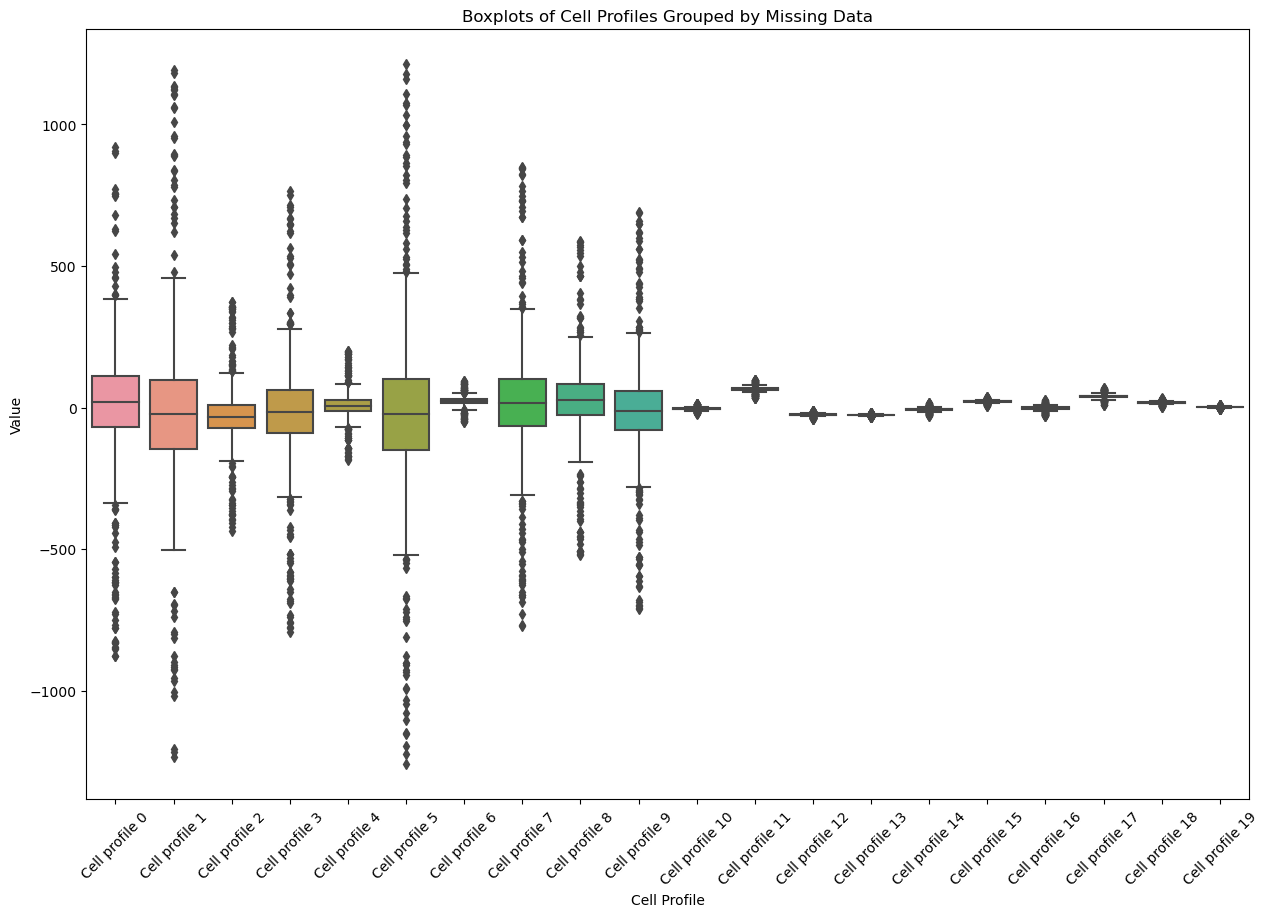

In [30]:
cell_profiles = [f"Cell profile {i}" for i in range(20)]
df_melted = pd.melt(dt, id_vars=['missing_data'], value_vars=cell_profiles)

# Create the boxplots
plt.figure(figsize=(15, 10))
sns.boxplot(x='variable', y='value', data=df_melted)
plt.xticks(rotation=45)
plt.title('Boxplots of Cell Profiles Grouped by Missing Data')
plt.xlabel('Cell Profile')
plt.ylabel('Value')
plt.show()

Missing data

In [9]:
dt['missing_data'] = dt.isna().any(axis=1) # One hot encoding on the na

In [19]:
print(dt.columns[:-1])
# Convert 'Sex' and 'Racial group' to categorical
dt['Sex'] = dt['Sex'].astype('category')
dt['Racial group'] = dt['Racial group'].astype('category')

Index(['Age (years)', 'Sex', 'Racial group', 'Cell profile 0',
       'Cell profile 1', 'Cell profile 2', 'Cell profile 3', 'Cell profile 4',
       'Cell profile 5', 'Cell profile 6', 'Cell profile 7', 'Cell profile 8',
       'Cell profile 9', 'Cell profile 10', 'Cell profile 11',
       'Cell profile 12', 'Cell profile 13', 'Cell profile 14',
       'Cell profile 15', 'Cell profile 16', 'Cell profile 17',
       'Cell profile 18', 'Cell profile 19', 'Survival time (years)'],
      dtype='object')


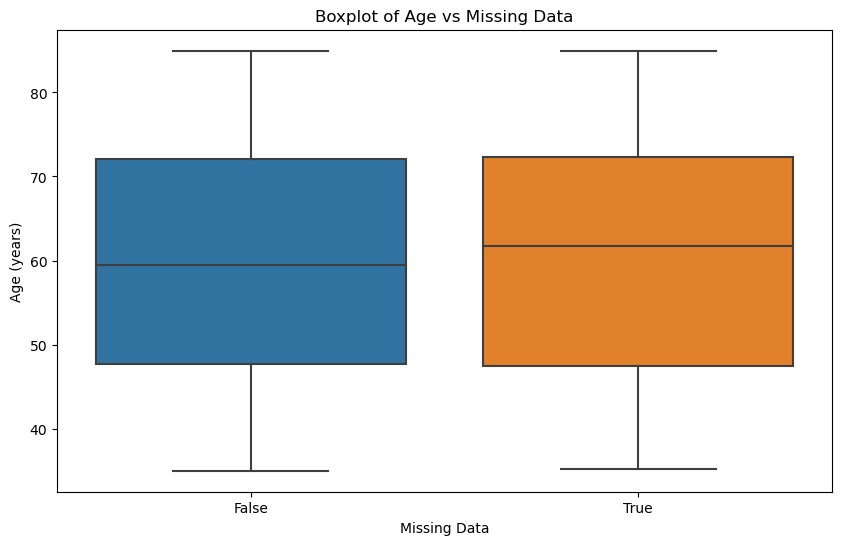

Sex           Female  Male  Total
Missing Data                     
False           1148  1030   2178
True             160   162    322
Total           1308  1192   2500


In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='missing_data', y='Age (years)', data=dt)

plt.title('Boxplot of Age vs Missing Data')
plt.xlabel('Missing Data')
plt.ylabel('Age (years)')
plt.show()

#
cross_tab = pd.crosstab(dt['missing_data'], dt['Sex'], margins=True, margins_name="Total")
cross_tab.index.name = "Missing Data"
cross_tab.columns.name = "Sex"
print(cross_tab)

Will just simple impute the data with the mean since only 25 are missing in some of the variables

In [41]:
# Identify truly numerical columns (int64 and float64 data types)
numerical_cols = dt.select_dtypes(include=['int64', 'float64']).columns

# Impute missing values in numerical columns with their mean  
dt[numerical_cols] = dt[numerical_cols].fillna(dt[numerical_cols].mean())



Handle outliers

In [60]:
#Test DBscan for funskies
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dt[cell_profiles])

dbscan = DBSCAN(eps=5, min_samples=100)
clusters = dbscan.fit_predict(scaled_data)
outliers = (clusters == -1)
dt['is_outlier'] = outliers
dt['is_outlier'].sum()





64

In [42]:
# Testing with normalization and scaling
# StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dt[cell_profiles])
print("Scaled Data (StandardScaler):\n", scaled_data)

# Normalizer
normalizer = Normalizer(norm='l2')  # 'l2' norm is default and results in Euclidean norm. You can also use 'l1' or 'max'.
normalized_data = normalizer.fit_transform(dt[cell_profiles])
print("\nNormalized Data:\n", normalized_data)

Scaled Data (StandardScaler):
 [[-0.15799281 -1.01728782 -0.02796466 ... -0.24498553  0.08989829
  -1.40028085]
 [ 0.46571394 -0.63885293  0.61239504 ...  0.402422    0.61988411
   0.69658016]
 [ 0.45498704 -0.85114363 -0.82862945 ...  0.39128799  0.34072888
   0.51881813]
 ...
 [-1.53111697  0.83874789  0.27015275 ...  4.68621058 -1.32606082
  -0.18865372]
 [-0.68198413  1.8602723  -0.17055263 ... -0.78888885 -1.04861495
   1.29272007]
 [ 0.72439638 -0.41523647  1.31649428 ...  0.67093523 -0.74514767
  -2.35166783]]

Normalized Data:
 [[-1.69446148e-02 -4.98020633e-01 -6.82102169e-02 ...  7.87295358e-02
   3.58805328e-02  5.12183025e-05]
 [ 1.30987757e-01 -2.21344022e-01  2.05025490e-02 ...  5.78569401e-02
   2.62405176e-02  4.04209461e-03]
 [ 2.72117110e-01 -6.04686609e-01 -2.73470418e-01 ...  1.22310869e-01
   5.32802003e-02  7.83792305e-03]
 ...
 [-6.21893657e-01  4.32722729e-01 -2.87941062e-02 ...  1.70854340e-01
   3.59042149e-02  4.49760188e-03]
 [-1.75912100e-01  7.18616108e-01